In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [279]:
from vol_surface.vol_surface_builder import VolSurfaceStore

In [280]:
from vol_surface.vol_surface_builder import dates, expire_dates, options_df

In [281]:
from vol_surface.vol_surface_builder import VS

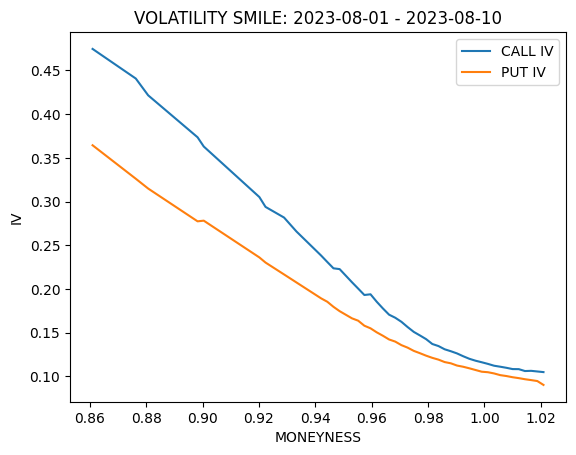

In [284]:
VS.get_surface(dates[0]).get_smile(expire_dates[7]).plot_smile()

In [285]:
VS.get_surface(dates[0]).get_smile(expire_dates[7]).df.head()

,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST,MONEYNESS
QUOTE_DATE,,,,,,
2023-08-01,2023-08-10,393.0,0.47452,0.36433,456.45,0.860992
2023-08-01,2023-08-10,400.0,0.44063,0.32602,456.45,0.876328
2023-08-01,2023-08-10,402.0,0.42145,0.31482,456.45,0.880710
2023-08-01,2023-08-10,410.0,0.37346,0.27733,456.45,0.898236
2023-08-01,2023-08-10,411.0,0.36290,0.27810,456.45,0.900427


In [302]:
smile_features = []

In [303]:
for quote_date in dates:
    surface = VS.get_surface(quote_date)
    for expire_date in expire_dates:
        smile_df = surface.get_smile(expire_date).df
        moneyness = np.array(smile_df['MONEYNESS'])
        iv = np.array(0.5*(smile_df['C_IV'] + smile_df['P_IV']))
        mask = ~ np.isnan(moneyness) & ~np.isnan(iv)
        x = moneyness[mask]
        y = iv[mask]
        if len(x)>5:
            coeffs = np.polyfit(x,y,2)
            poly = np.poly1d(coeffs)
        
            atm_iv = poly(1.0)
            skew = poly.deriv()(1.0)
            curvature = poly.deriv(2)(1.0)
        
            smile_features.append({
            'quote_date': quote_date,
            'expire_date': expire_date,
            'atm_iv': atm_iv,
            'skew': skew,
            'curvature': curvature
            })
    
        

In [309]:
smile_features = pd.DataFrame(smile_features)

In [310]:
len(smile_features)

7901

In [311]:
smile_features.head()

,quote_date,expire_date,atm_iv,skew,curvature
0,2023-08-01,2023-08-01,0.368407,-5.294118,79.521206
1,2023-08-01,2023-08-02,0.075963,-5.731881,11.236018
2,2023-08-01,2023-08-03,0.097738,-4.005577,9.032630
3,2023-08-01,2023-08-04,0.103226,-3.435891,4.026443
4,2023-08-01,2023-08-07,0.097024,-1.872508,14.080939


In [312]:
smile_features.set_index(['quote_date', 'expire_date'])

atm_iv       skew  curvature
quote_date expire_date                                
2023-08-01 2023-08-01   0.368407  -5.294118  79.521206
           2023-08-02   0.075963  -5.731881  11.236018
           2023-08-03   0.097738  -4.005577   9.032630
           2023-08-04   0.103226  -3.435891   4.026443
           2023-08-07   0.097024  -1.872508  14.080939
...                          ...        ...        ...
2023-11-30 2024-04-19   0.145563  -0.298787   2.130352
           2024-04-30   0.139461  -0.449585   1.233271
           2024-05-31   0.146054  -0.431213   1.074053
           2024-09-30   0.158493  -0.367022   0.532029
           2023-11-30   0.248333 -10.547483  25.515759

[7901 rows x 3 columns]

In [314]:
smile_features = smile_features.to_csv('data/smile_features.csv')